In [29]:
pip install geopandas osmnx networkx matplotlib folium pandas numpy contextily

In [30]:
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import folium
from folium.plugins import HeatMap
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.ops import unary_union
import contextily as ctx
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

In [31]:
place_name = "Piedmont, California, USA"

In [32]:
gdf_area = ox.geocode_to_gdf(place_name)
G = ox.graph_from_place(place_name, network_type='drive')
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
tags = {'landuse': True, 'amenity': ['school', 'hospital', 'clinic'], 'leisure': ['park', 'playground']}
gdf_features = ox.features_from_place(place_name, tags=tags)
print(f"Data collection complete. Found {len(gdf_features)} features.")

Data collection complete. Found 63 features.


Mapping land use

Land use map saved to 'land_use_map.png'


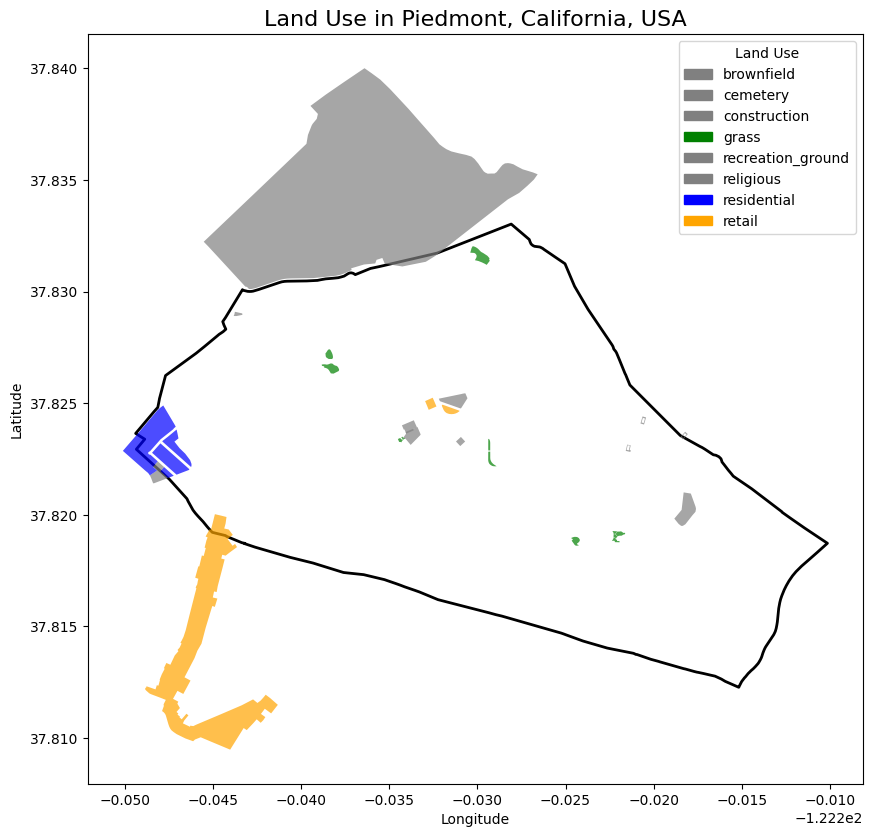

In [33]:
landuse_polygons = gdf_features[
    (gdf_features.geom_type.isin(['Polygon', 'MultiPolygon'])) &
    (gdf_features['landuse'].notna())
]
landuse_colors = {'residential': 'blue', 'commercial': 'red', 'industrial': 'purple', 'grass': 'green', 'forest': 'darkgreen', 'retail': 'orange'}
fig, ax = plt.subplots(figsize=(10, 10))
gdf_area.plot(ax=ax, color='none', edgecolor='black', linewidth=2)
legend_patches = []
for ctype, data in landuse_polygons.groupby('landuse'):
    color = landuse_colors.get(ctype, 'gray')
    data.plot(ax=ax, color=color, alpha=0.7)
    legend_patches.append(mpatches.Patch(color=color, label=ctype))
ax.set_title(f"Land Use in {place_name}", fontsize=16)
ax.legend(handles=legend_patches, title='Land Use')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig("land_use_map.png")
print("Land use map saved to 'land_use_map.png'")

Analyzing accessibility (isochrones)

Accessibility map saved to 'accessibility_isochrones.png'


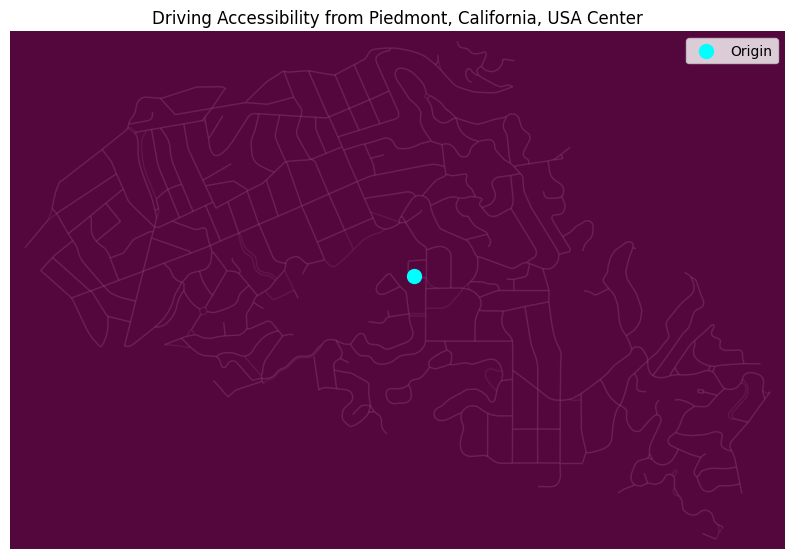

In [34]:
G_proj = ox.project_graph(G)
center_point_geom = gdf_area.union_all().centroid
center_point_latlon = (center_point_geom.y, center_point_geom.x)
center_node_orig = ox.distance.nearest_nodes(G, X=center_point_latlon[1], Y=center_point_latlon[0])
trip_times = [5, 10]
trip_times_seconds = [t * 60 for t in trip_times]
travel_times = nx.single_source_dijkstra_path_length(G, center_node_orig, weight='travel_time')
isochrone_polys = []
for trip_time in trip_times_seconds:
    sub_nodes = [node for node, time in travel_times.items() if time <= trip_time]
    subgraph = G.subgraph(sub_nodes)
    nodes_proj, edges_proj = ox.graph_to_gdfs(subgraph, nodes=True, edges=True)
    polygon = edges_proj.buffer(200).unary_union
    isochrone_polys.append((trip_time, polygon))
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0, figsize=(10, 10))
colors = ['blue', 'red']
for (trip_time, poly), color in zip(isochrone_polys, colors):
    if isinstance(poly, (Polygon, MultiPolygon)):
        gpd.GeoSeries([poly], crs=gdf_area.crs).plot(ax=ax, color=color, alpha=0.3, label=f"{trip_time/60:.0f} min")
ax.scatter(center_point_latlon[1], center_point_latlon[0], color='cyan', s=100, zorder=5, label='Origin')
ax.set_title(f"Driving Accessibility from {place_name} Center")
ax.legend()
plt.savefig("accessibility_isochrones.png")
print("Accessibility map saved to 'accessibility_isochrones.png'")


Identifying areas with poor park access

Park access map saved to 'park_access.png'


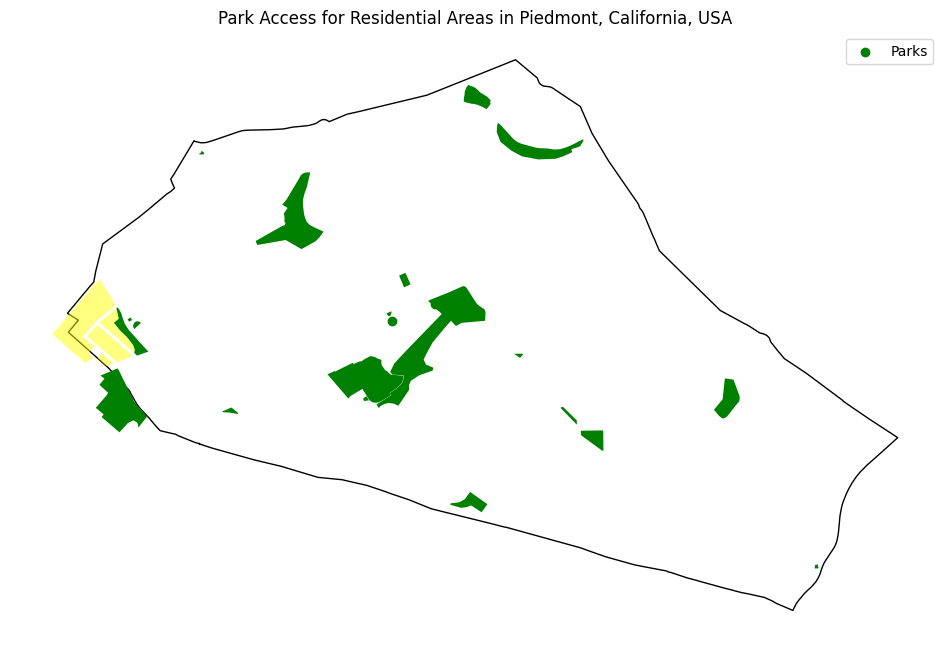

In [35]:
parks = gdf_features[gdf_features['leisure'].isin(['park', 'playground'])]
residential = landuse_polygons[landuse_polygons['landuse'] == 'residential']
if not parks.empty and not residential.empty:
    crs_proj = G_proj.graph['crs']
    parks_proj = parks.to_crs(crs_proj)
    residential_proj = residential.to_crs(crs_proj)
    area_proj = gdf_area.to_crs(crs_proj)
    walking_distance = 500
    park_buffers = parks_proj.buffer(walking_distance)
    park_service_area = park_buffers.union_all()
    underserved_residential = residential_proj.overlay(gpd.GeoDataFrame(geometry=[park_service_area], crs=crs_proj), how='difference')
    fig_access, ax_access = plt.subplots(figsize=(12, 10))
    area_proj.plot(ax=ax_access, color='none', edgecolor='black', label='City Boundary')
    residential_proj.plot(ax=ax_access, color='yellow', alpha=0.5, label='All Residential')
    parks_proj.plot(ax=ax_access, color='green', label='Parks')
    if not underserved_residential.empty:
        underserved_residential.plot(ax=ax_access, color='red', label='Underserved Residential (>500m to Park)')
    ax_access.set_title(f"Park Access for Residential Areas in {place_name}")
    ax_access.legend()
    plt.axis('off')
    plt.savefig("park_access.png")
    print("Park access map saved to 'park_access.png'")
else:
    print("Skipping park access analysis: No parks or residential areas found.")


Generating population heatmap

In [36]:
num_points = 2000
minx, miny, maxx, maxy = gdf_area.union_all().bounds
area_polygon = gdf_area.union_all()
sim_points = []
while len(sim_points) < num_points:
    p = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
    if area_polygon.contains(p):
        sim_points.append(p)
gdf_pop = gpd.GeoDataFrame(geometry=sim_points, crs=gdf_area.crs)
map_center = [gdf_area.centroid.y, gdf_area.centroid.x]
m = folium.Map(location=map_center, zoom_start=14, tiles="cartodbdarkmatter")
folium.GeoJson(gdf_area, style_function=lambda x: {'color': 'white', 'weight': 2, 'fillOpacity': 0}).add_to(m)
heat_data = [[point.y, point.x] for point in gdf_pop.geometry]
HeatMap(heat_data, radius=15, blur=10).add_to(m)
m.save("population_heatmap.html")


In [37]:
print("\n--- Analysis Complete ---")
print("Generated files:")
print("- land_use_map.png")
print("- accessibility_isochrones.png")
if not parks.empty and not residential.empty:
    print("- park_access.png")
print("- population_heatmap.html")


--- Analysis Complete ---
Generated files:
- land_use_map.png
- accessibility_isochrones.png
- park_access.png
- population_heatmap.html


#CONCLUSION

The urban spatial analysis of Piedmont, California successfully integrated geospatial and network-based methods to assess land use, accessibility, and service distribution. The study identified key zoning areas including residential, commercial, industrial, and green spaces. Network analysis revealed travel-time accessibility zones, highlighting areas within 5–10 minutes from the city center. Park accessibility mapping indicated certain residential regions with limited access to nearby green spaces. Additionally, the population heatmap provided insights into density distribution across the city. Overall, the project demonstrates an effective geospatial approach for understanding urban structure, accessibility, and planning needs.